In [115]:
import pandas as pd
import glob
import os
import datetime
import pvlib
from pv_model import model_pv_power
import matplotlib.pyplot as plt
import scipy
import numpy as np

In [2]:
## API key credentials are stored in a separate text file
with open('nrel_api_key_details.txt') as f: # full path and filename of text file with api key on first line
    email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
    api_key = f.readline().rstrip() 

In [3]:
folder = 'output_specs' 
filelist = glob.glob(os.path.join(folder , '*_specs.csv'))
df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

# replace empty strings with NaN
df = df.replace(' ', np.nan)

num_plants = len(df)

C:\Users\willh\AppData\Local\Temp\ipykernel_26540\3833113069.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(' ', np.nan)


Since EIA nameplates seem to be off (sometimes it includes multiple units, other times I'm not sure what's happening), let's normalize EIA AC and DC nameplate based on the ratio of EIA AC to CDR AC nameplates. 

In [4]:
ratios = df['cdr file nameplate ac mw'] / df['eia solar Nameplate Capacity (MW)']
df['eia nameplate ac'] = df['eia nameplate ac']*ratios
df['eia solar Nameplate Capacity (MW)'] = df['eia solar Nameplate Capacity (MW)'] * ratios
df['eia solar DC Net Capacity (MW)'] = df['eia solar DC Net Capacity (MW)'] * ratios

In [5]:
# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*20240101.csv'))

Function to convert EIA specs to pv_model parameters:

In [6]:
def eia_specs_to_pv_model_params(plant_data):

    # basics
    latitude = plant_data['Latitude']
    longitude = plant_data['Longitude']
    nameplate_dc = plant_data['DC Net Capacity (MW)']
    nameplate_ac = plant_data['Nameplate Capacity (MW)']
    
    # commercial operation date
    cod = datetime.datetime(
        int(plant_data['Operating Year']),
        int(plant_data['Operating Month']),
        1, # assume first day of the month
        ) 

    # mounting type
    if plant_data['Single-Axis Tracking?'] == 'Y':
        mount_type = 'single-axis'
    elif plant_data['Fixed Tilt?'] == 'Y':
        mount_type = 'fixed'
    else:
        raise ValueError('plant does not appear to be fixed or single-axis')

    # shade loss.  Use linear for cdte, for crystalline we don't have info about twin cells/modules,
    # so assume twin (half-cut) after a given date
    twin_module_start_date = pd.to_datetime('2020-01-01') # TODO: needs to be verified, maybe in ITRPV 2020 or 2021?
    if plant_data['Thin-Film (CdTe)?'] == 'Y':
        shade_loss_model = 'linear'
        cell_type = 'thin-film_cdte' # for spectral correction
        n_cells_up = 1
    elif (
        plant_data['Thin-Film (A-Si)?'] == 'Y' or
        plant_data['Thin-Film (CIGS)?'] == 'Y' or
        plant_data[ 'Thin-Film (Other)?'] == 'Y'
    ):
        shade_loss_model = 'linear'
        n_cells_up = 1
    elif plant_data['Crystalline Silicon?'] == 'Y':
        cell_type = 'crystalline'
        if cod > twin_module_start_date:
            shade_loss_model = 'non-linear_simple_twin_module'
            n_cells_up = 24
        else:
            shade_loss_model = 'non-linear_simple'
            n_cells_up = 12
        
    # bifacial
    if plant_data['Bifacial?'] == 'Y':
        bifacial = True
        bifaciality_factor = 0.8 # TODO: consider changing this based on COD
    else:
        bifacial = False
        bifaciality_factor = pd.NA

    # backtracking
    if (
        mount_type == 'single-axis' and
        shade_loss_model == 'linear'
    ):
        backtrack = False
    else:
        backtrack = True

    # gcr 
    if mount_type == 'fixed':
        gcr = 0.55
    elif mount_type == 'single-axis' and cell_type == 'crystalline':
        gcr = 0.35
    elif mount_type == 'single-axis':
        gcr = 0.40

    # modules up each row 
    if mount_type == 'fixed' and cell_type == 'crystalline':
        row_side_num_mods = 2
    else:
        # assume crystalline trackers are 1P,
        # doesn't matter for linear shade loss configurations
        row_side_num_mods = 1

    # tilt and azimuth
    if mount_type == 'fixed':
        # assume tilt and azimuth are correct for fixed systems
        fixed_azimuth = plant_data['Azimuth Angle']
        fixed_tilt = plant_data['Tilt Angle']
        axis_azimuth = pd.NA
        axis_tilt = pd.NA
    elif mount_type == 'single-axis':
        # sometimes EIA has the wrong azimuth for trackers, e.g., they enter tilt
        if plant_data['Azimuth Angle'] > 90 and plant_data['Azimuth Angle'] < 270:
            axis_azimuth = plant_data['Azimuth Angle']
        else:
            axis_azimuth = 180
        # sometimes EIA has the wrong tilt for trackers, e.g., they enter max rotation angle
        if isinstance(plant_data['Tilt Angle'],str):
            axis_tilt = 0
        elif plant_data['Tilt Angle'] < 15:
            axis_tilt = plant_data['Tilt Angle']
        else:
            axis_tilt = 0
        fixed_azimuth = pd.NA
        fixed_tilt = pd.NA

    # temperature coefficient
    # TODO: consider changing this based on COD
    if cell_type == 'crystalline':
        gamma_pdc = -0.0035
    else:
        gamma_pdc = -0.0025

    # dc derate
    dc_loss_fraction_base = 0.15
    annual_degradation = 0.005 # assume 0.5%/yr PLR
    years_oper = (pd.Timestamp.now() - cod).days / 365.25 # TODO: make this based analysis time, not time right now
    degr_loss = years_oper * annual_degradation
    dc_loss_fraction = 1 - ((1 - dc_loss_fraction_base) * (1 - degr_loss))

    plant_data_new = {
        'latitude': latitude,
        'longitude': longitude,
        'nameplate_dc': nameplate_dc,
        'nameplate_ac': nameplate_ac,
        'mount_type': mount_type,
        'cell_type': cell_type,
        'shade_loss_model': shade_loss_model,
        'bifacial': bifacial,
        'bifaciality_factor': bifaciality_factor,
        'backtrack': backtrack,
        'gcr': gcr,
        'row_side_num_mods': row_side_num_mods,
        'fixed_azimuth': fixed_azimuth,
        'fixed_tilt': fixed_tilt,
        'axis_azimuth': axis_azimuth,
        'axis_tilt': axis_tilt,
        'gamma_pdc': gamma_pdc,
        'dc_loss_fraction': dc_loss_fraction,
        'n_cells_up': n_cells_up,
        'cod': cod,
    }

    return plant_data_new

Functions for calculating error as a function of different modeling parameters, to be used later in `scipy.optimize.minimize` to optimaze the parameter values.

In [7]:
def dc_loss_error(dc_loss_fraction, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'dc_loss_fraction': dc_loss_fraction,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)

    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def gamma_pdc_error(gamma_pdc, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'gamma_pdc': gamma_pdc,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def gcr_error(gcr, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'gcr': gcr,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def axis_azimuth_error(axis_azimuth, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'axis_azimuth': axis_azimuth,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def fixed_azimuth_error(fixed_azimuth, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'fixed_azimuth': fixed_azimuth,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def axis_tilt_error(axis_tilt, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'axis_tilt': axis_tilt,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

def fixed_tilt_error(fixed_tilt, combined_variables):
    power_actual = combined_variables[0]
    resource = combined_variables[1]
    plant_data_new = combined_variables[2]
    plant_data_new = {
        **plant_data_new,
        'fixed_tilt': fixed_tilt,
    }
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    
    # filter small values, resample to hourly, calculate abs error
    thresh = power_actual.max() * .05
    power_actual = power_actual.resample('1h').mean()
    power_expected = power_expected.resample('1h').mean()
    abs_err = (power_expected[power_actual > thresh] - power_actual[power_actual > thresh]).abs().sum()
    return abs_err

And code to look through each plant, download NSRDB data, and then optimize key specs. 

_Note: Optimizing tilt and azimuth is commented out for now. I had mixed results, and decided that EIA specs (with QC filters for things like 90 deg azimuth) was probably reliable._

In [8]:
year = 2023 # for NSRDB
agg_specs_orig = {}
agg_specs_opt = {}
agg_hsl = {}
agg_tel_net_out = {}
agg_power_expected = {}
agg_power_expected_opt = {}

for plant_number in range(num_plants):
    ## Get plant metadata ready
    # =====================================================
    # select a row from dataframe and convert to dictionary
    # plant_data = df.iloc[plant_number].dropna().to_dict()
    plant_data = df.iloc[plant_number].to_dict()

    # select keys that start with 'eia_solar'
    prefix = 'eia solar'
    plant_data = {key: val for key, val in plant_data.items()
            if key.startswith(prefix)}

    # remove prefix
    plant_data = {key.lstrip(prefix):value for key, value in plant_data.items()}

    # convert EIA parameters to pv_model parameters
    plant_data_new = eia_specs_to_pv_model_params(plant_data)

    # get resource data
    resource, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data_new['latitude'],
        plant_data_new['longitude'],
        api_key,
        email,
        year,
        time_step=15,
        utc=True)
    
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # new parameter dictionary to be iteratively optimized
    plant_data_opt = plant_data_new

    # parameters to pass to functions
    combined_variables = {}
    combined_variables[0]=df_ts['hsl']
    # combined_variables[0]=df_ts['telemetered_net_output']
    combined_variables[1]=resource
    combined_variables[2]=plant_data_opt

    # tracking w/ bifacial is about 30x slower, likely due to infinite sheds
    # so, lets' resample to hours (4x savings) and use the first quarter of the dataset (4x, combined 16x savings)
    if plant_data_opt['bifacial'] == True and plant_data_opt['mount_type'] == 'single-axis':
        combined_variables[0] = combined_variables[0].resample('1h').mean()
        combined_variables[1] = combined_variables[1].resample('1h').mean()
        combined_variables[0] = combined_variables[0][:len(combined_variables[0]) // 4].copy()
        combined_variables[1] = combined_variables[1][:len(combined_variables[1]) // 4].copy()

    # optimize DC loss, then gcr, then gamma_pdc, then axis_azimuth (if it's tracking) or fixed_azimuth (if it's fixed), then tilt:
    out = scipy.optimize.minimize(dc_loss_error, plant_data_opt['dc_loss_fraction'],
                                  combined_variables, bounds=[(-.1,.95)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'dc_loss_fraction': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    out = scipy.optimize.minimize(gcr_error, plant_data_opt['gcr'], combined_variables, bounds=[(.1,.8)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'gcr': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    out = scipy.optimize.minimize(gamma_pdc_error, plant_data_opt['gamma_pdc'], combined_variables, bounds=[(-.008, -.0005)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'gamma_pdc': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    # if plant_data_opt['mount_type'] == 'single-axis':
    #     out = scipy.optimize.minimize(axis_azimuth_error, plant_data_opt['axis_azimuth'], combined_variables, bounds=[(90.0,270.0)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'axis_azimuth': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt

    #     # out = scipy.optimize.minimize(axis_tilt_error, plant_data_opt['axis_tilt'], combined_variables, bounds=[(-5,20)], method = "Nelder-Mead")
    #     # plant_data_opt = {
    #     #     **plant_data_opt,
    #     #     'axis_tilt': out['x'][0],
    #     # }
    #     # combined_variables[2]=plant_data_opt

    # elif plant_data_opt['mount_type'] == 'fixed':
    #     out = scipy.optimize.minimize(fixed_azimuth_error, plant_data_opt['fixed_azimuth'], combined_variables, bounds=[(90,270)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'fixed_azimuth': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt

    #     out = scipy.optimize.minimize(fixed_tilt_error, plant_data_opt['fixed_tilt'], combined_variables, bounds=[(0,60)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'fixed_tilt': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt
    
    # model power before and after optimizing parameters
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    power_expected_opt, _ = model_pv_power(resource, **plant_data_opt)
    
    # outputs
    agg_specs_orig[plant_number] = plant_data_new
    agg_specs_opt[plant_number] = plant_data_opt
    agg_hsl[plant_number] = df_ts['hsl']
    agg_tel_net_out[plant_number] = df_ts['telemetered_net_output']
    agg_power_expected[plant_number] = power_expected
    agg_power_expected_opt[plant_number] = power_expected_opt

    print('done with plant ' + str(plant_number))



done with plant 0
done with plant 1
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifacial.infinite_sheds does not currently accept the perez-driesse model.
using haydavies instead.
pvlib.bifa

In [9]:
agg_specs_orig_df = pd.DataFrame(agg_specs_orig)
agg_specs_opt_df = pd.DataFrame(agg_specs_opt)
agg_hsl_df = pd.concat(agg_hsl, axis=1)
agg_tel_net_out_df = pd.concat(agg_tel_net_out, axis=1)
agg_power_expected_df = pd.concat(agg_power_expected, axis=1)
agg_power_expected_opt_df = pd.concat(agg_power_expected_opt, axis=1)

In [10]:
agg_specs_orig_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis
cell_type,crystalline,thin-film_cdte,crystalline,thin-film_cdte,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,thin-film_cdte
shade_loss_model,non-linear_simple_twin_module,linear,non-linear_simple_twin_module,linear,non-linear_simple,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple,non-linear_simple_twin_module,non-linear_simple,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple,linear
bifacial,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
bifaciality_factor,<NA>,<NA>,0.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.8,<NA>,<NA>,<NA>,<NA>,<NA>
backtrack,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False


In [11]:
agg_specs_opt_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
latitude,32.811041,31.719983,33.021601,31.888,31.255,33.404486,30.4214,28.883196,31.435932,31.030996,32.104125,33.467803,32.4744,32.460054,32.533273,34.380532,26.090103,33.261505,29.271667,29.242304
longitude,-99.91749,-104.442292,-99.61463,-100.825,-102.272,-96.082472,-97.4614,-99.178605,-99.796613,-102.488209,-100.162375,-95.370856,-95.7156,-102.672809,-96.428985,-100.099625,-97.798453,-97.238057,-98.444722,-95.658144
nameplate_dc,131.5944,256.362179,94.507156,130.434783,234.0,170.854369,186.0,176.0,319.0,172.362353,143.08,260.0,82.098305,133.931,182.009816,165.306333,184.861111,191.275636,53.936118,162.4
nameplate_ac,100.8,188.2,74.9,100.0,180.0,125.7,144.0,132.4,250.0,126.3,102.2,198.5,59.8,100.7,147.6,121.4,137.5,148.8,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis
cell_type,crystalline,thin-film_cdte,crystalline,thin-film_cdte,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,thin-film_cdte
shade_loss_model,non-linear_simple_twin_module,linear,non-linear_simple_twin_module,linear,non-linear_simple,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple,non-linear_simple_twin_module,non-linear_simple,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple,linear
bifacial,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
bifaciality_factor,<NA>,<NA>,0.8,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.8,<NA>,<NA>,<NA>,<NA>,<NA>
backtrack,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False


In [12]:
agg_hsl_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
interval_start_utc,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.5,0.0,0.1,0.0,0.1,0.0,0.1
2023-01-01 00:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.1
2023-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.1
2023-01-01 00:45:00+00:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.1
2023-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.0,0.1,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00+00:00,45.3,103.4,23.8,47.8,95.1,17.7,34.4,68.9,95.1,34.3,43.9,10.4,7.7,51.6,30.5,32.4,52.8,34.9,10.3,10.5
2023-12-31 23:00:00+00:00,27.3,82.9,12.8,32.9,70.1,6.9,18.3,42.9,58.8,23.0,30.0,5.3,3.7,34.9,8.2,4.9,32.9,16.3,5.7,2.4
2023-12-31 23:15:00+00:00,9.5,58.9,4.9,18.9,42.9,1.4,6.8,19.5,27.4,11.3,16.5,2.5,0.8,18.3,3.0,1.8,13.1,2.1,2.7,0.0


In [13]:
agg_tel_net_out_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
interval_start_utc,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,0.0,0.00000,0.00666,0.000,0.00000,0.0,0.00,0.0,0.00,0.0,0.00,0.00000,0.00000,0.00001,0.000,0.0,0.0,0.00000,0.00000,0.0
2023-01-01 00:15:00+00:00,0.0,0.00000,0.00666,0.000,0.00000,0.0,0.00,0.0,0.00,0.0,0.00,0.00000,0.00000,0.00001,0.000,0.0,0.0,0.00000,0.00000,0.0
2023-01-01 00:30:00+00:00,0.0,0.00000,0.00666,0.000,0.00000,0.0,0.00,0.0,0.00,0.0,0.00,0.00000,0.00000,0.00001,0.000,0.0,0.0,0.00000,0.00000,0.0
2023-01-01 00:45:00+00:00,0.0,0.00000,0.00666,0.000,0.00000,0.0,0.00,0.0,0.00,0.0,0.00,0.00000,0.00000,0.00001,0.000,0.0,0.0,0.00000,0.00000,0.0
2023-01-01 01:00:00+00:00,0.0,0.00000,0.00666,0.000,0.00000,0.0,0.00,0.0,0.00,0.0,0.00,0.00000,0.00000,0.00001,0.000,0.0,0.0,0.00000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00+00:00,45.3,103.31603,23.73633,47.375,95.05011,17.6,34.37,68.8,95.02,34.1,37.60,10.43365,5.28004,51.49001,32.283,32.3,52.7,34.86525,10.25969,10.5
2023-12-31 23:00:00+00:00,27.3,82.87299,12.74991,32.257,70.09408,6.9,18.27,42.8,58.73,23.0,22.89,5.28433,3.47476,34.77001,3.655,4.9,32.8,16.22129,5.70983,2.4
2023-12-31 23:15:00+00:00,9.5,58.87878,4.91685,18.306,42.95379,1.4,6.78,19.5,27.35,11.3,10.82,2.52367,0.77284,18.27001,3.292,1.8,13.0,2.10082,2.67992,0.0


In [14]:
agg_power_expected_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2023-01-01 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:15:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:45:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 01:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00+00:00,39.160151,112.646637,26.840181,42.208164,94.189559,13.344447,47.651643,59.400683,102.897709,72.508743,46.637843,11.333609,6.946380,52.734083,34.087521,43.880072,62.155990,38.122354,15.722004,7.393603
2023-12-31 23:00:00+00:00,24.686532,88.366071,16.502640,30.541561,68.004005,5.987208,28.240689,40.161585,67.621467,52.690326,30.642680,4.653794,3.044919,38.154739,16.953453,26.420230,41.632155,6.791641,10.205324,7.243751
2023-12-31 23:15:00+00:00,11.647008,64.000234,7.335526,19.576738,41.897680,0.881288,11.532418,22.071063,34.863980,33.261252,15.732554,0.150411,0.626541,23.313243,4.229499,11.065424,22.662229,5.312288,5.159925,0.448132
2023-12-31 23:30:00+00:00,2.503102,40.832623,1.390233,9.265428,18.725844,0.000000,1.581957,7.251677,9.154083,15.514331,4.264050,0.000000,0.000000,10.062174,0.000000,1.779634,7.491480,0.000000,1.312929,0.000000


In [15]:
agg_power_expected_opt_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2023-01-01 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:15:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:30:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 00:45:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-01 01:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 22:45:00+00:00,39.971927,106.153111,25.802607,45.443615,74.304483,8.174494,30.414353,53.798412,97.394886,38.119291,38.470333,10.056422,4.949025,48.645535,34.482666,36.223140,50.375769,30.570371,11.609153,5.176842
2023-12-31 23:00:00+00:00,25.332462,83.035051,15.840439,32.794939,53.438260,3.770715,17.579266,36.149797,63.468388,27.410870,25.075699,4.238491,2.309367,35.561817,17.066992,21.544570,33.514320,6.338869,7.406967,5.071047
2023-12-31 23:15:00+00:00,11.999859,59.861319,7.027078,20.886371,32.689617,0.419474,7.160688,19.745219,32.525013,17.029335,12.757901,0.072415,0.473450,21.955917,4.283751,8.974854,18.119662,4.250996,3.707814,0.127328
2023-12-31 23:30:00+00:00,2.564440,37.854172,1.321492,9.828007,14.472004,0.000000,1.061472,6.483742,8.614460,7.717029,3.420315,0.000000,0.000000,9.537913,0.000000,1.542764,5.983953,0.000000,0.974239,0.000000


Some of those `dc_loss_fraction` values did not look good:

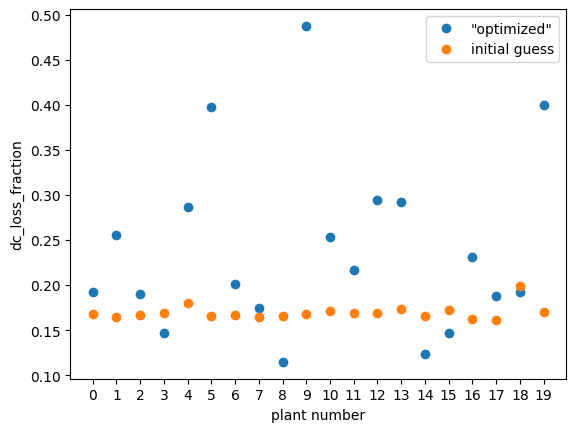

In [16]:
agg_specs_opt_df.loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='"optimized"')
agg_specs_orig_df.loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='initial guess')
plt.legend()
plt.xticks(agg_specs_opt_df.columns)
plt.ylabel('dc_loss_fraction')
plt.xlabel('plant number')
plt.show()

Let's look at the ones with data for all of 2021:

In [17]:
max_date = datetime.datetime.strptime('2021-01-1', '%Y-%m-%d')
agg_specs_opt_df.loc[:, (agg_specs_opt_df.loc[['cod']] < max_date).all()]

,3,4,10,11,12,13,15,18,19
latitude,31.888,31.255,32.104125,33.467803,32.4744,32.460054,34.380532,29.271667,29.242304
longitude,-100.825,-102.272,-100.162375,-95.370856,-95.7156,-102.672809,-100.099625,-98.444722,-95.658144
nameplate_dc,130.434783,234.0,143.08,260.0,82.098305,133.931,165.306333,53.936118,162.4
nameplate_ac,100.0,180.0,102.2,198.5,59.8,100.7,121.4,39.2,120.0
mount_type,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis,single-axis
cell_type,thin-film_cdte,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,crystalline,thin-film_cdte
shade_loss_model,linear,non-linear_simple,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple_twin_module,non-linear_simple,non-linear_simple,non-linear_simple,linear
bifacial,False,False,False,False,False,False,False,False,False
bifaciality_factor,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
backtrack,False,True,True,True,True,True,True,True,False


In [18]:
filtered_cols = agg_specs_opt_df.loc[:, (agg_specs_opt_df.loc[['cod']] < max_date).all()].columns.to_list()

# add number 9 since I know it has data for all of 2021
filtered_cols.append(9)
filtered_cols.sort()

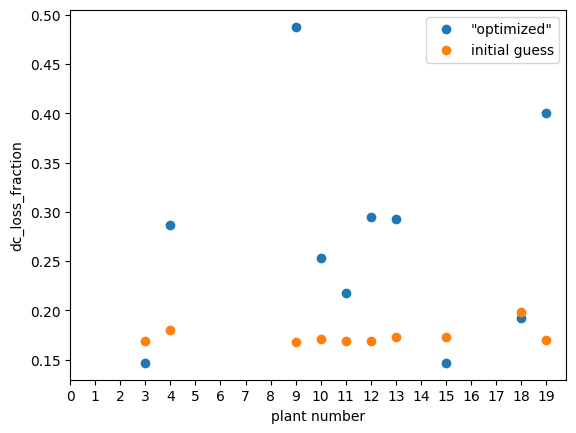

In [19]:
agg_specs_opt_df[filtered_cols].loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='"optimized"')
agg_specs_orig_df[filtered_cols].loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='initial guess')
plt.legend()
plt.xticks(agg_specs_opt_df.columns)
plt.ylabel('dc_loss_fraction')
plt.xlabel('plant number')
plt.show()

In [116]:
# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*20150101-20250501.csv'))

# plants 5, 9, 19 have especially high apparent dc_loss_fraction

# 4, 12, 13 are next (~29%)
# starts:
# 5: 2021-06
# 9: 2020-08
# 19: 2020-06?
# 4: 2018-11
# 12: 2021-10
# 13: 2019-10
plant_number = 9

# read in timeseries data from ERCOT
ts_file = filelist_ts[plant_number]
df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
     
df_ts.head()

,interval_end_utc,sced_timestamp_utc,qse,dme,resource_name,resource_type,telemetered_resource_status,output_schedule,hsl,hasl,...,as_responsibility_for_nonspin,as_responsibility_for_ecrs,sced1_offer_curve,start_up_cold_offer,start_up_hot_offer,start_up_inter_offer,min_gen_cost,sced_tpo_offer_curve,UNIT NAME,UNIT CODE
interval_start_utc,,,,,,,,,,,,,,,,,,,,,
2020-08-05 05:00:00+00:00,2020-08-05 05:15:00+00:00,2020-08-05 05:00:35+00:00,NaN,NaN,GREASWOD_UNIT1,PVGR,NaN,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, 1500.0]]",NaN,NaN,NaN,NaN,[],GREASEWOOD SOLAR 1,NaN
2020-08-05 05:15:00+00:00,2020-08-05 05:30:00+00:00,2020-08-05 05:15:15+00:00,NaN,NaN,GREASWOD_UNIT1,PVGR,NaN,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, 1500.0]]",NaN,NaN,NaN,NaN,[],GREASEWOOD SOLAR 1,NaN
2020-08-05 05:30:00+00:00,2020-08-05 05:45:00+00:00,2020-08-05 05:30:16+00:00,NaN,NaN,GREASWOD_UNIT1,PVGR,NaN,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, 1500.0]]",NaN,NaN,NaN,NaN,[],GREASEWOOD SOLAR 1,NaN
2020-08-05 05:45:00+00:00,2020-08-05 06:00:00+00:00,2020-08-05 05:45:17+00:00,NaN,NaN,GREASWOD_UNIT1,PVGR,NaN,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, 1500.0]]",NaN,NaN,NaN,NaN,[],GREASEWOOD SOLAR 1,NaN
2020-08-05 06:00:00+00:00,2020-08-05 06:15:00+00:00,2020-08-05 06:00:23+00:00,NaN,NaN,GREASWOD_UNIT1,PVGR,NaN,0.0,0.0,0.0,...,0.0,NaN,"[[0.0, -250.0], [0.0, 1500.0]]",NaN,NaN,NaN,NaN,[],GREASEWOOD SOLAR 1,NaN


<Axes: xlabel='interval_start_utc'>

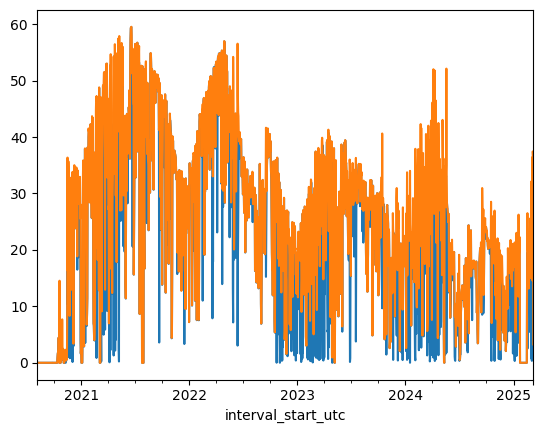

In [21]:
df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts['hsl'].astype(float).resample('D').mean().plot()

Repeat for plants have data in 2021, analyzing 2021.

In [22]:
custom_plant_number_list = filtered_cols
custom_time_start = '2021-01-01'
custom_time_end = '2022-01-01'
year=2021 #for nsrdb

# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*20150101-20250501.csv'))

agg_specs_orig_custom = {}
agg_specs_opt_custom = {}
agg_hsl_custom = {}
agg_tel_net_out_custom = {}
agg_power_expected_custom = {}
agg_power_expected_opt_custom = {}

for plant_number in custom_plant_number_list:
    ## Get plant metadata ready
    # =====================================================
    # select a row from dataframe and convert to dictionary
    # plant_data = df.iloc[plant_number].dropna().to_dict()
    plant_data = df.iloc[plant_number].to_dict()

    # select keys that start with 'eia_solar'
    prefix = 'eia solar'
    plant_data = {key: val for key, val in plant_data.items()
            if key.startswith(prefix)}

    # remove prefix
    plant_data = {key.lstrip(prefix):value for key, value in plant_data.items()}

    # convert EIA parameters to pv_model parameters
    plant_data_new = eia_specs_to_pv_model_params(plant_data)

    # get resource data
    resource, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data_new['latitude'],
        plant_data_new['longitude'],
        api_key,
        email,
        year,
        time_step=15,
        utc=True)
    
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # filter to custom time range
    df_ts = df_ts[(df_ts.index >= custom_time_start) & (df_ts.index < custom_time_end)].copy()

    # new parameter dictionary to be iteratively optimized
    plant_data_opt = plant_data_new

    # parameters to pass to functions
    combined_variables = {}
    combined_variables[0]=df_ts['hsl']
    # combined_variables[0]=df_ts['telemetered_net_output']
    combined_variables[1]=resource
    combined_variables[2]=plant_data_opt

    # tracking w/ bifacial is about 30x slower, likely due to infinite sheds
    # so, lets' resample to hours (4x savings) and use the first quarter of the dataset (4x, combined 16x savings)
    if plant_data_opt['bifacial'] == True and plant_data_opt['mount_type'] == 'single-axis':
        combined_variables[0] = combined_variables[0].resample('1h').mean()
        combined_variables[1] = combined_variables[1].resample('1h').mean()
        combined_variables[0] = combined_variables[0][:len(combined_variables[0]) // 4].copy()
        combined_variables[1] = combined_variables[1][:len(combined_variables[1]) // 4].copy()

    # optimize DC loss, then gcr, then gamma_pdc, then axis_azimuth (if it's tracking) or fixed_azimuth (if it's fixed), then tilt:
    out = scipy.optimize.minimize(dc_loss_error, plant_data_opt['dc_loss_fraction'],
                                  combined_variables, bounds=[(-.1,.95)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'dc_loss_fraction': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    out = scipy.optimize.minimize(gcr_error, plant_data_opt['gcr'], combined_variables, bounds=[(.1,.8)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'gcr': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    out = scipy.optimize.minimize(gamma_pdc_error, plant_data_opt['gamma_pdc'], combined_variables, bounds=[(-.008, -.0005)], method = "Nelder-Mead")
    plant_data_opt = {
        **plant_data_opt,
        'gamma_pdc': out['x'][0],
    }
    combined_variables[2]=plant_data_opt

    # if plant_data_opt['mount_type'] == 'single-axis':
    #     out = scipy.optimize.minimize(axis_azimuth_error, plant_data_opt['axis_azimuth'], combined_variables, bounds=[(90.0,270.0)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'axis_azimuth': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt

    #     # out = scipy.optimize.minimize(axis_tilt_error, plant_data_opt['axis_tilt'], combined_variables, bounds=[(-5,20)], method = "Nelder-Mead")
    #     # plant_data_opt = {
    #     #     **plant_data_opt,
    #     #     'axis_tilt': out['x'][0],
    #     # }
    #     # combined_variables[2]=plant_data_opt

    # elif plant_data_opt['mount_type'] == 'fixed':
    #     out = scipy.optimize.minimize(fixed_azimuth_error, plant_data_opt['fixed_azimuth'], combined_variables, bounds=[(90,270)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'fixed_azimuth': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt

    #     out = scipy.optimize.minimize(fixed_tilt_error, plant_data_opt['fixed_tilt'], combined_variables, bounds=[(0,60)], method = "Nelder-Mead")
    #     plant_data_opt = {
    #         **plant_data_opt,
    #         'fixed_tilt': out['x'][0],
    #     }
    #     combined_variables[2]=plant_data_opt
    
    # model power before and after optimizing parameters
    power_expected, _ = model_pv_power(resource, **plant_data_new)
    power_expected_opt, _ = model_pv_power(resource, **plant_data_opt)
    
    # outputs
    agg_specs_orig_custom[plant_number] = plant_data_new
    agg_specs_opt_custom[plant_number] = plant_data_opt
    agg_hsl_custom[plant_number] = df_ts['hsl']
    agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']
    agg_power_expected_custom[plant_number] = power_expected
    agg_power_expected_opt_custom[plant_number] = power_expected_opt

    print('done with plant ' + str(plant_number))

done with plant 3
done with plant 4
done with plant 9
done with plant 10
done with plant 11
done with plant 12
done with plant 13
done with plant 15
done with plant 18
done with plant 19


In [23]:
agg_specs_orig_custom_df = pd.DataFrame(agg_specs_orig_custom)
agg_specs_opt_custom_df = pd.DataFrame(agg_specs_opt_custom)
agg_hsl_custom_df = pd.concat(agg_hsl_custom, axis=1)
agg_tel_net_out_custom_df = pd.concat(agg_tel_net_out_custom, axis=1)
agg_power_expected_custom_df = pd.concat(agg_power_expected_custom, axis=1)
agg_power_expected_opt_custom_df = pd.concat(agg_power_expected_opt_custom, axis=1)

Here are the optimized specs from 2021:

In [24]:
agg_specs_opt_custom_df.loc[['gcr','gamma_pdc','dc_loss_fraction']][custom_plant_number_list]

,3,4,9,10,11,12,13,15,18,19
gcr,0.378473,0.394156,0.414668,0.377325,0.457034,0.472355,0.326463,0.429647,0.457119,0.454998
gamma_pdc,-0.002617,-0.003259,-0.002001,-0.003438,-0.003393,-0.002471,-0.003882,-0.002534,-0.002678,-0.003251
dc_loss_fraction,0.097458,0.191836,0.174415,0.255886,0.162422,0.217459,0.200023,0.159629,0.211804,0.264032


And here they are for 2023:

In [25]:
agg_specs_opt_df.loc[['gcr','gamma_pdc','dc_loss_fraction']][custom_plant_number_list]

,3,4,9,10,11,12,13,15,18,19
gcr,0.375955,0.38418,0.406478,0.379453,0.465664,0.486855,0.322353,0.425391,0.470142,0.430254
gamma_pdc,-0.002611,-0.004034,-0.003953,-0.00335,-0.003455,-0.003377,-0.004382,-0.003155,-0.003315,-0.003413
dc_loss_fraction,0.146971,0.286276,0.487652,0.253481,0.217183,0.294667,0.292454,0.14658,0.19177,0.399783


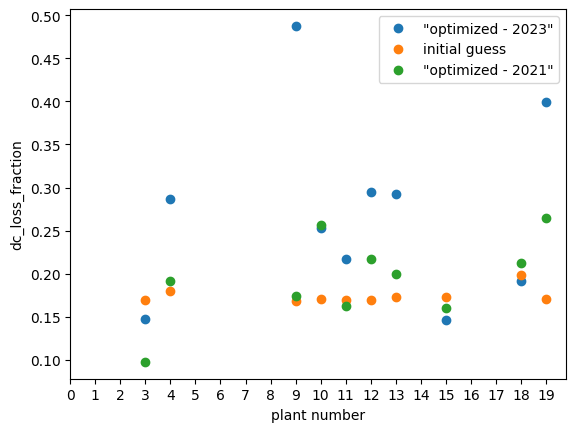

In [26]:
agg_specs_opt_df[filtered_cols].loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='"optimized - 2023"')
agg_specs_orig_df[filtered_cols].loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='initial guess')
agg_specs_opt_custom_df[filtered_cols].loc['dc_loss_fraction'].plot(marker='o', linestyle='', label='"optimized - 2021"')
plt.legend()
plt.xticks(agg_specs_opt_df.columns)
plt.ylabel('dc_loss_fraction')
plt.xlabel('plant number')
plt.show()

In [27]:
agg_specs_opt_df.loc[['bifacial','gcr','gamma_pdc','dc_loss_fraction']][custom_plant_number_list]

,3,4,9,10,11,12,13,15,18,19
bifacial,False,False,False,False,False,False,False,False,False,False
gcr,0.375955,0.38418,0.406478,0.379453,0.465664,0.486855,0.322353,0.425391,0.470142,0.430254
gamma_pdc,-0.002611,-0.004034,-0.003953,-0.00335,-0.003455,-0.003377,-0.004382,-0.003155,-0.003315,-0.003413
dc_loss_fraction,0.146971,0.286276,0.487652,0.253481,0.217183,0.294667,0.292454,0.14658,0.19177,0.399783


Model 3 years with the original EIA-based specs:

In [28]:
custom_plant_number_list = filtered_cols

custom_time_start = '2021-01-01'
custom_time_end = '2024-01-01'

# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*20150101-20250501.csv'))

agg_hsl_custom = {}
agg_tel_net_out_custom = {}
agg_power_expected_custom = {}
agg_power_expected_opt_custom = {}

for plant_number in custom_plant_number_list:
    plant_data = agg_specs_orig[plant_number]

    # get resource data
    resource1, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2021,
        time_step=15,
        utc=True)
    
    resource2, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2022,
        time_step=15,
        utc=True)
    
    resource3, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2023,
        time_step=15,
        utc=True)
    
    resource = pd.concat([resource1,resource2,resource3],axis=0)
    
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # filter to custom time range
    df_ts = df_ts[(df_ts.index >= custom_time_start) & (df_ts.index < custom_time_end)].copy()
    
    # model power
    power_expected, _ = model_pv_power(resource, **plant_data)
    
    agg_power_expected_custom[plant_number] = power_expected
    agg_hsl_custom[plant_number] = df_ts['hsl']
    agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']
    
    print('done with plant ' + str(plant_number))

done with plant 3
done with plant 4
done with plant 9
done with plant 10
done with plant 11
done with plant 12
done with plant 13
done with plant 15
done with plant 18
done with plant 19


Plot a sample time range:

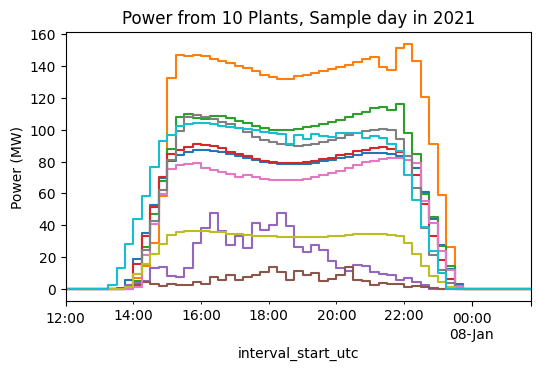

In [ ]:
start = '2021-01-07 12:00'
end = '2021-01-08 02:00'

for plant_number in custom_plant_number_list:
    power = agg_tel_net_out_custom[plant_number][(agg_tel_net_out_custom[plant_number].index >= start) & (agg_tel_net_out_custom[plant_number].index < end)]
    power.plot(drawstyle='steps-pre',label=('plant #: ' + str(plant_number)),figsize=(6,3.5))
plt.ylabel('Power (MW)')
plt.title('Power from 10 Plants, Sample day in ' + str(power.index.year[0]))
plt.savefig("images/sample.png", dpi=400, bbox_inches='tight')
plt.show()

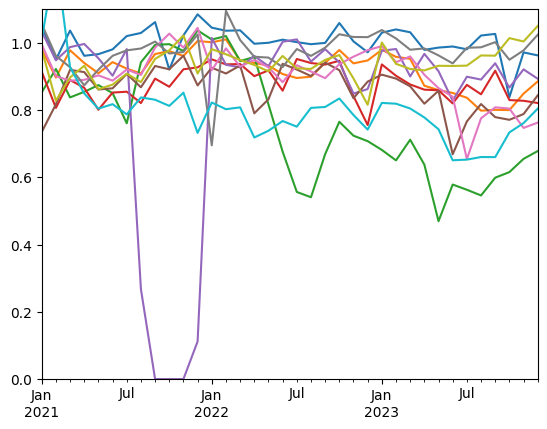

In [ ]:
for plant_number in custom_plant_number_list:

    (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot()#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.show()

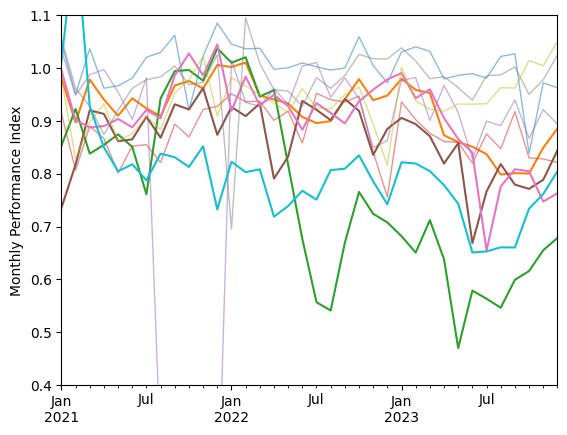

In [ ]:
for plant_number in custom_plant_number_list:

    if plant_number in [4,9,12,13,19]:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number)#drawstyle='steps-pre')
    else:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number, linewidth=1, alpha=0.5)#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0.4,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.ylabel('Monthly Performance Index')
# plt.legend()
plt.show()

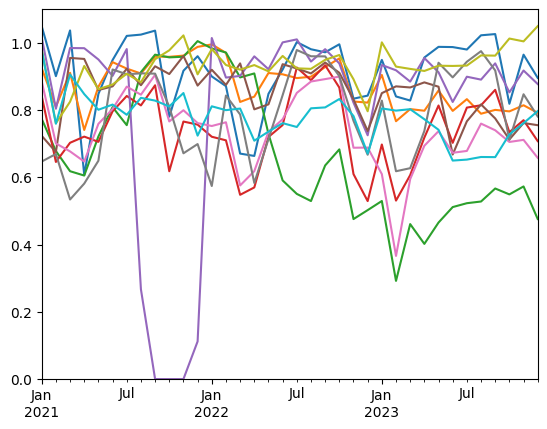

In [ ]:
for plant_number in custom_plant_number_list:

    (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot()#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.show()

Model the 3 years with optimized specs:

In [ ]:
custom_plant_number_list = filtered_cols

custom_time_start = '2021-01-01'
custom_time_end = '2024-01-01'
year=2021 #for nsrdb

# timeseries data files
folder_ts = 'output_timeseries' 
filelist_ts = glob.glob(os.path.join(folder_ts, '*20150101-20250501.csv'))

agg_hsl_custom = {}
agg_tel_net_out_custom = {}
agg_power_expected_custom = {}
agg_power_expected_opt_custom = {}

for plant_number in custom_plant_number_list:
    ## Get plant metadata ready
    # =====================================================
    # select a row from dataframe and convert to dictionary
    # plant_data = df.iloc[plant_number].dropna().to_dict()
    plant_data = agg_specs_opt_custom[plant_number]

    # get resource data
    resource1, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2021,
        time_step=15,
        utc=True)
    
    resource2, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2022,
        time_step=15,
        utc=True)
    
    resource3, metadata = pvlib.iotools.get_nsrdb_psm4_conus(
        plant_data['latitude'],
        plant_data['longitude'],
        api_key,
        email,
        year=2023,
        time_step=15,
        utc=True)
    
    resource = pd.concat([resource1,resource2,resource3],axis=0)
    
    # read in timeseries data from ERCOT
    ts_file = filelist_ts[plant_number]
    df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning
    
    # filter to custom time range
    df_ts = df_ts[(df_ts.index >= custom_time_start) & (df_ts.index < custom_time_end)].copy()
    
    # model power
    power_expected, _ = model_pv_power(resource, **plant_data)
    
    agg_power_expected_custom[plant_number] = power_expected
    agg_hsl_custom[plant_number] = df_ts['hsl']
    agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']
    
    print('done with plant ' + str(plant_number))

done with plant 3
done with plant 4
done with plant 9
done with plant 10
done with plant 11
done with plant 12
done with plant 13
done with plant 15
done with plant 18
done with plant 19


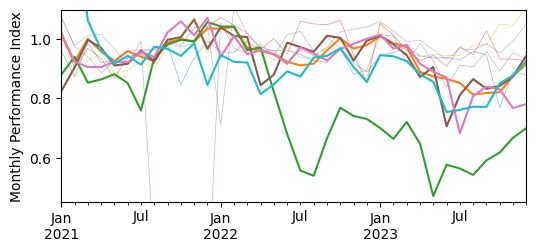

In [92]:
for plant_number in custom_plant_number_list:

    if plant_number in [4,9,12,13,19]:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number)#drawstyle='steps-pre')
    else:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number, linewidth=0.5, alpha=0.5)#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0.45,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.ylabel('Monthly Performance Index')
plt.gcf().set_size_inches(6, 2.5)
plt.savefig("images/PI.png", dpi=400, bbox_inches='tight')
plt.show()
plt.show()

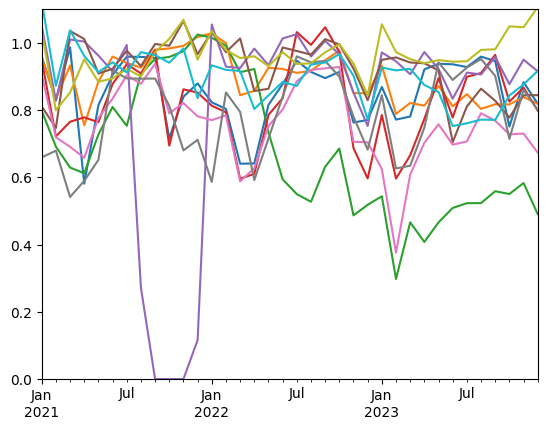

In [35]:
for plant_number in custom_plant_number_list:
    # agg_power_expected_custom[plant_number] = power_expected
    # agg_hsl_custom[plant_number] = df_ts['hsl']
    # agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']

    (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot()#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.show()

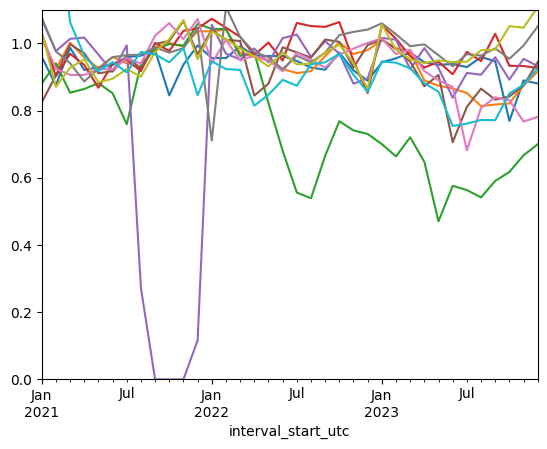

In [36]:
for plant_number in custom_plant_number_list:
    # agg_power_expected_custom[plant_number] = power_expected
    # agg_hsl_custom[plant_number] = df_ts['hsl']
    # agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']

    (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot()#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0,1.1])
plt.show()

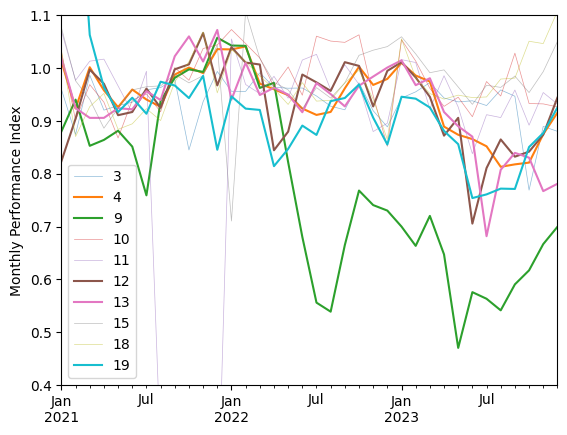

In [37]:
for plant_number in custom_plant_number_list:
    # agg_power_expected_custom[plant_number] = power_expected
    # agg_hsl_custom[plant_number] = df_ts['hsl']
    # agg_tel_net_out_custom[plant_number] = df_ts['telemetered_net_output']

    if plant_number in [4,9,12,13,19]:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number)#drawstyle='steps-pre')
    else:
        (agg_hsl_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('ME').mean()).plot(label=plant_number, linewidth=0.5, alpha=0.5)#drawstyle='steps-pre')
    # (agg_tel_net_out_custom[plant_number].resample('ME').mean() / agg_power_expected_custom[plant_number].resample('YE').mean()).plot()#drawstyle='steps-pre')
plt.ylim([0.4,1.1])
plt.gca().xaxis.label.set_visible(False)
plt.ylabel('Monthly Performance Index')
# plt.savefig("images/PI.png", dpi=400, bbox_inches='tight')
plt.legend()
plt.show()
plt.show()

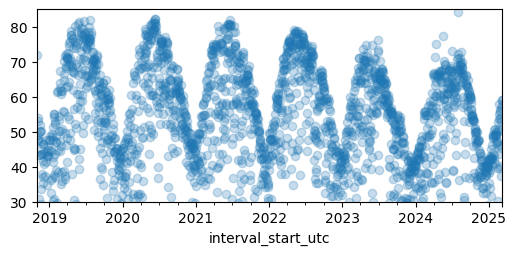

In [63]:
plant_number = 4
ts_file = filelist_ts[plant_number]
df_ts_4 = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning


# df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts_4['hsl'].astype(float).resample('D').mean().plot(marker='o', linestyle='', alpha=0.25, figsize=(6,2.5))
plt.ylim([30,85])
plt.savefig("images/daily_avg_power_4.png", dpi=400, bbox_inches='tight')

<Axes: xlabel='interval_start_utc'>

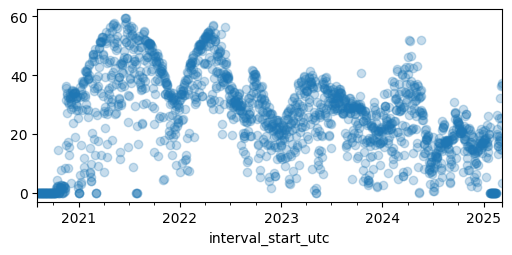

In [117]:
plant_number = 9
ts_file = filelist_ts[plant_number]
df_ts_9 = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning

# df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts_9['hsl'].astype(float).resample('D').mean().plot(marker='o', linestyle='', alpha=0.25, figsize=(6,2.5))

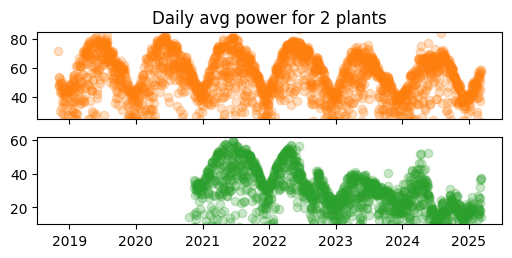

In [93]:
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,2.5) )
ax1.plot(df_ts_4['hsl'].astype(float).resample('D').mean().index,
         df_ts_4['hsl'].astype(float).resample('D').mean(),
         marker='o', linestyle='', alpha=0.25, color='C1')
ax1.set_title('Daily avg power for 2 plants')
ax1.set_ylim([25,85])
ax2.plot(df_ts_9['hsl'].astype(float).resample('D').mean().index,
         df_ts_9['hsl'].astype(float).resample('D').mean(),
         marker='o', linestyle='', alpha=0.25, color='C2')
ax2.set_ylim([10,62])

plt.savefig("images/daily_power.png", dpi=400, bbox_inches='tight')

Plant 9 seems to have major intermittent curtailment going on?

<Axes: xlabel='interval_start_utc'>

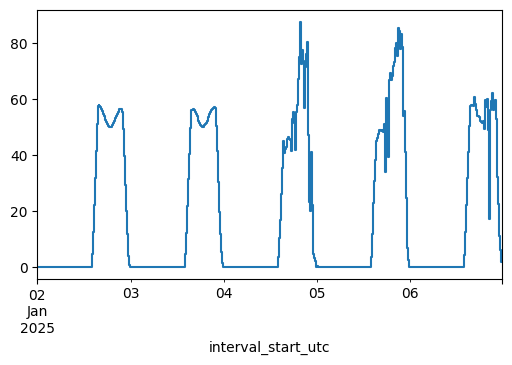

In [119]:
start = '2025-01-02'
end = '2025-01-07'

power = df_ts_9['hsl'][(df_ts_9['hsl'].index >= start) & (df_ts_9['hsl'].index < end)]
power.plot(drawstyle='steps-pre',label=('plant #: ' + str(plant_number)),figsize=(6,3.5))

<Axes: xlabel='interval_start_utc'>

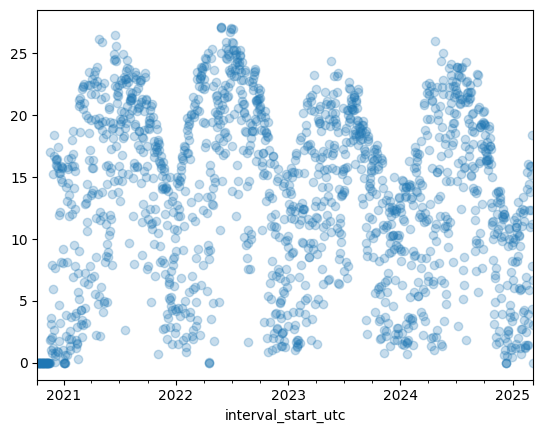

In [55]:
plant_number = 12
ts_file = filelist_ts[plant_number]
df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning

# df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts['hsl'].astype(float).resample('D').mean().plot(marker='o', linestyle='', alpha=0.25)

<Axes: xlabel='interval_start_utc'>

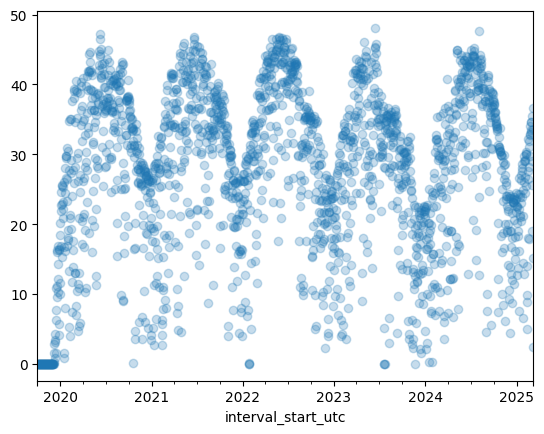

In [94]:
plant_number = 13
ts_file = filelist_ts[plant_number]
df_ts_13 = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning

# df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts_13['hsl'].astype(float).resample('D').mean().plot(marker='o', linestyle='', alpha=0.25)

(15.0, 50.0)

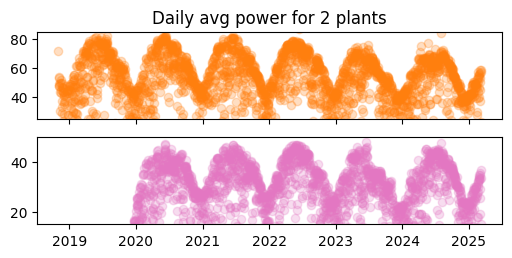

In [99]:
# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,2.5) )
ax1.plot(df_ts_4['hsl'].astype(float).resample('D').mean().index,
         df_ts_4['hsl'].astype(float).resample('D').mean(),
         marker='o', linestyle='', alpha=0.25, color='C1')
ax1.set_title('Daily avg power for 2 plants')
ax1.set_ylim([25,85])
ax2.plot(df_ts_13['hsl'].astype(float).resample('D').mean().index,
         df_ts_13['hsl'].astype(float).resample('D').mean(),
         marker='o', linestyle='', alpha=0.25, color='C6')
ax2.set_ylim([15,50])

# plt.savefig("images/daily_power.png", dpi=400, bbox_inches='tight')

(0.0, 55.0)

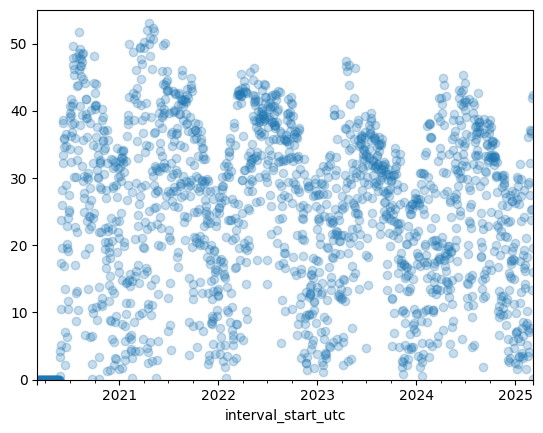

In [58]:
plant_number = 19
ts_file = filelist_ts[plant_number]
df_ts = pd.read_csv(ts_file,index_col=0,parse_dates=True,low_memory=False) #low_memory=False to avoid mixed variable type warning

# df_ts['telemetered_net_output'].astype(float).resample('D').mean().plot()
df_ts['hsl'].astype(float).resample('D').mean().plot(marker='o', linestyle='', alpha=0.25)
plt.ylim([0,55])